# EG Intern Assessment
#### Christian Rouhana

This Python notebook will serve a sort of worksheet for my assessment. I hope it can give you an insight into my skillset and thought process. Please e-mail me at rouhanachristian@gmail.com if you have any questions. All answers are marked with 'ANSWER:' at the beginning


# Loading Data, Packages, Defining Functions

In [32]:
# import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from scipy import stats
from scipy.stats import iqr
from IPython.display import display_html 
import collections
import datetime as dt

plt.style.use('ggplot') 

In [4]:
# mounting my google drive to import assessment data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load into Pandas DataFrame
data = pd.read_excel('drive/MyDrive/EG Assignment/social_data.xlsx')

In [6]:
# These were added as I refactored my code
def get_stats_dict(col,unique_vals, source_data=None):
  if source_data is None:
    source_data = engagement #refactoring
  data_dict = {}
  for val in unique_vals:
    df = source_data[source_data[col] == val]
    df0 = df.describe()
    data_dict[val] = {'data':df, 'stats':df0.T.drop('DoW', axis = 0)}
  return data_dict

# https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
def print_stats_dict(stats_dict, labels, vals):
  html_stylers = []
  for i in range(len(labels)):
    styler = stats_dict[vals[i]]['stats'].style.set_table_attributes(
      "style='display:newline'").set_caption(labels[i])
    html_stylers.append(styler._repr_html_())
  display_html(html_stylers, raw=True)
  return 

# many boxplots ahead...
def display_boxplot(data_dict, column, lbls, title, xlabel, ylabel, vals, c1='white', c2='black'):
  boxplot = [data_dict[val]['data'][column] for val in vals]
  plt.boxplot(boxplot, positions=[i*2 for i in range(len(lbls))],labels=lbls, 
                widths=1, patch_artist=True,
                showmeans=False, showfliers=False,
                medianprops={"color": c1, "linewidth": 0.5},
                boxprops={"facecolor": c2, "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": c2, "linewidth": 1.5},
                capprops={"color": c2, "linewidth": 1.5})
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()
  return

# Question 1

(Part 1)What is the typical engagement rate we can expect? (Part 2)What's the likelihood that we can achieve a 15% engagement rate?

## Part 1

My first steps will be to do some basic data cleaning and get the mean and standard deviation from the dataset. 

I will be calculating engagement rate for each row by the following method: Let $E$ be total engagements, $I$ be total impressions, and $R_e$ be the engagement rate.

$ R_{e} = \frac{E}{I} $

In [7]:
# basic stuff first, clean data, calculate engagement rates for each row

# cut rows with no engagement/impression data
engagement = data[data['Total Impressions'] != 0] 

# cut rows with more engagements than impressions
engagement = engagement[
    engagement['Total Engagements'] < engagement['Total Impressions']
    ] 

# calculate engagement rate
engagement_rates = []
for i, row in engagement.iterrows():
  engagement_rates.append(row['Total Engagements']/row['Total Impressions'])
engagement['Engagement Rate'] = engagement_rates # adding this column makes later coding faster

# fetch normal descriptive stats
df_describe = pd.DataFrame(engagement_rates) 
stat_dict = df_describe.describe().T
stat_dict = stat_dict.drop(columns=['count'])
stat_dict['iqr'] = stat_dict['75%']  - stat_dict['25%']
stat_dict

,mean,std,min,25%,50%,75%,max,iqr
0,0.0524,0.068149,0.0,0.014184,0.030513,0.060903,0.6,0.04672


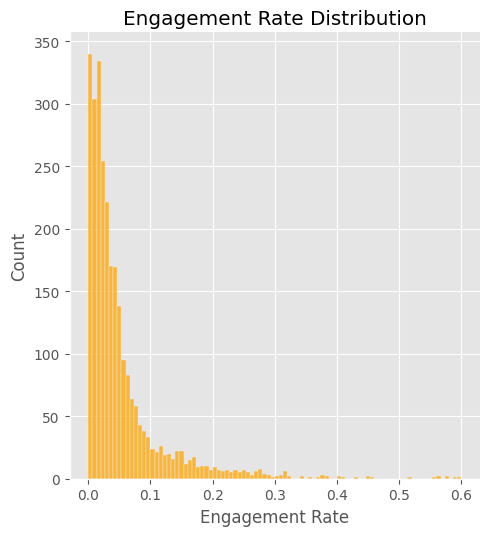

In [8]:
# plot distirbution of engagement rates, I feel like a histogram
ax = sns.displot(engagement_rates, color = 'orange').set(title='Engagement Rate Distribution')
ax.set(xlabel='Engagement Rate', ylabel='Count')

In [9]:
# getting probabilities of 5% buckets
l = 0.00
r = 0.05
probs = []
while l < r <= 0.6:
  count = 0
  for val in engagement_rates:
    if l <= val and val < r:
      count += 1
  probs.append(count/len(engagement_rates))
  l += 0.05
  r += 0.05

table_labels = [
    'P(x < 0.05)', 'P(0.05 <= x < 0.1)', 'P(0.1 <= x < 0.15)', 
    'P(0.15 <= x < 0.2)', 'P(0.2 <= x < 0.25)', 'P(0.25 <= x < 0.3)',
    'P(0.3 <= x < 0.35)', 'P(0.35 <= x < 0.4)', 'P(0.4 <= x < 0.45)',
    'P(0.45 <= x < 0.5)', 'P(0.5 <= x < 0.55)', 'P(0.55 <= x < 0.6)'
  ]

table_dict = {'P(x)': table_labels, 'Probability': probs}

df = pd.DataFrame(table_dict)
df

,P(x),Probability
0,P(x < 0.05),0.683861
1,P(0.05 <= x < 0.1),0.179808
2,P(0.1 <= x < 0.15),0.057480
3,P(0.15 <= x < 0.2),0.034635
4,P(0.2 <= x < 0.25),0.017686
5,P(0.25 <= x < 0.3),0.012896
6,P(0.3 <= x < 0.35),0.005527
7,P(0.35 <= x < 0.4),0.002579
8,P(0.4 <= x < 0.45),0.002211
9,P(0.45 <= x < 0.5),0.000368


ANSWER: The above table shows that nearly 86.37% of engagement rates fall between 0-10%, with 68.39% of the data falling under 5%. This, alongside with the mean of 5.24%, median of 3.05%, and standard deviation of 6.81% make me believe the typical engagement rate we will see is around 0-5%.

## Part 2

In [10]:
# likelihood we an achieve a 15% engagement rate
# assumption: the probability we achieve a minimuim 15% engagement rate (> 15% acceptable)
k = 0.15
count = reduce(lambda sum, j:sum+(1 if j >= k else 0), engagement_rates, 0)
print('{}%'.format(
    round(100 * (count / len(engagement_rates)), 2)
    )
)

7.89%


ANSWER: The probability that we can achieve a minimum 15% engagement rate is 7.89%

# Question 2

Does day of the week and time of posting affect engagement rates?

In [33]:
# first thing, create day of week column
days = []
for i, row in engagement.iterrows():
  days.append(row['Published Date'].weekday()) # date column already in timestamp format
engagement['DoW'] = days # 'DoW' == Day of Week
days_code = [0,1,2,3,4,5,6]
# Get time of day column
engagement['Time'] = pd.to_datetime(engagement['Published Date']).dt.time
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

In [21]:
dow_dict = get_stats_dict('DoW', days_code)
stylers = print_stats_dict(dow_dict, days, days_code)

,count,mean,std,min,25%,50%,75%,max
Total Impressions,186.000000,13311.983871,27330.219530,24.000000,738.500000,2909.500000,15013.500000,209875.000000
Total Engagements,186.000000,893.973118,3245.323119,0.000000,18.000000,67.500000,207.500000,29860.000000
Engagement Rate,186.000000,0.045173,0.058147,0.000000,0.012931,0.028385,0.048378,0.379310
,count,mean,std,min,25%,50%,75%,max
Total Impressions,430.000000,16481.581395,49741.010163,1.000000,1123.000000,4326.000000,17496.750000,753227.000000
Total Engagements,430.000000,1612.041860,5851.992483,0.000000,23.250000,101.500000,637.250000,95062.000000
Engagement Rate,430.000000,0.062733,0.075630,0.000000,0.017542,0.038047,0.076272,0.564800
,count,mean,std,min,25%,50%,75%,max
Total Impressions,429.000000,13371.687646,28659.218897,22.000000,910.000000,2842.000000,14936.000000,256502.000000
Total Engagements,429.000000,1045.491841,3615.507886,0.000000,13.000000,54.000000,361.000000,41102.000000


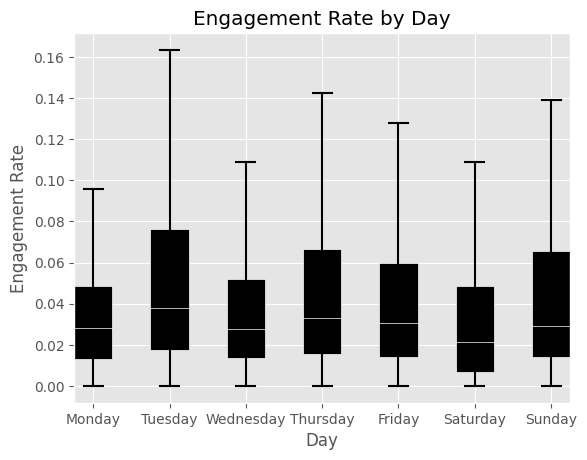

In [13]:
display_boxplot(dow_dict, 'Engagement Rate', days, 'Engagement Rate by Day', 
                'Day', 'Engagement Rate', days_code)

In [24]:
dow_dict[0]['data'].head()

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate,DoW,Time
218,2023-03-27 22:18:00.313,CSGO,TWITTER,Community Engagement,894,9,Photo,0.010067,0,22:18:00.313000
219,2023-03-27 21:11:28.792,CSGO,TWITTER,Community Engagement,1219,14,Photo,0.011485,0,21:11:28.792000
220,2023-03-27 20:05:41.540,CSGO,TWITTER,Community Engagement,691,7,Photo,0.010130,0,20:05:41.540000
221,2023-03-27 19:04:39.208,CSGO,TWITTER,Community Engagement,2200,36,Photo,0.016364,0,19:04:39.208000
222,2023-03-27 17:08:22.061,CSGO,TWITTER,Community Engagement,727,7,Photo,0.009629,0,17:08:22.061000


In [48]:
# how does time of each day impact ER?
# assumptions:
#   morning : 00:00 - 6:00
#   mid-morning: 6:00 - 12:00
#   afternoon : 12:00 - 18:00
#   evening: 18:00 - 24:00

days_dict = {
    0:'Monday',1:'Tuesday',2:'Wednesday',
    3:'Thursday',4:'Friday',5:'Saturday',
    6:'Sunday'
    }

time_dict = {
    0:[],1:[],2:[],3:[],4:[],5:[],6:[]
}
for day in dow_dict.keys():
  # print all descriptive stats for each timeframe on each day
  print(days_dict[day])
  current = dow_dict[day]['data']
  print('Morning')
  morning = current[dt.time(0, 0) <= current['Time']]
  morning = current[current['Time'] < dt.time(12, 0)]
  time_dict[day].append(morning['Engagement Rate'])
  print(morning.describe().drop('DoW',axis = 1))
  print()
  print('Afternoon')
  afternoon = current[dt.time(12, 0) <= current['Time']]
  afternoon = current[current['Time'] < dt.time(18, 0)]
  time_dict[day].append(afternoon['Engagement Rate'])
  print(afternoon.describe().drop('DoW',axis = 1))
  print()
  print('Evening')
  evening = current[dt.time(18, 0) <= current['Time']]
  evening = current[current['Time'] <= dt.time(23, 59)]
  time_dict[day].append(evening['Engagement Rate'])
  print(evening.describe().drop('DoW',axis = 1))
  print()
  print()


Monday
Morning
       Total Impressions  Total Engagements  Engagement Rate
count          72.000000          72.000000        72.000000
mean        19612.944444        1497.888889         0.049302
std         38334.120769        4458.782483         0.053719
min            26.000000           1.000000         0.002553
25%           667.750000          27.000000         0.021176
50%          2692.000000          68.500000         0.034313
75%         22475.250000         359.750000         0.054187
max        209875.000000       29860.000000         0.320279

Afternoon
       Total Impressions  Total Engagements  Engagement Rate
count         175.000000         175.000000       175.000000
mean        13890.314286         944.685714         0.046222
std         28044.567099        3339.637414         0.059537
min            24.000000           0.000000         0.000000
25%           789.500000          19.000000         0.012987
50%          3194.000000          71.000000         0.02868

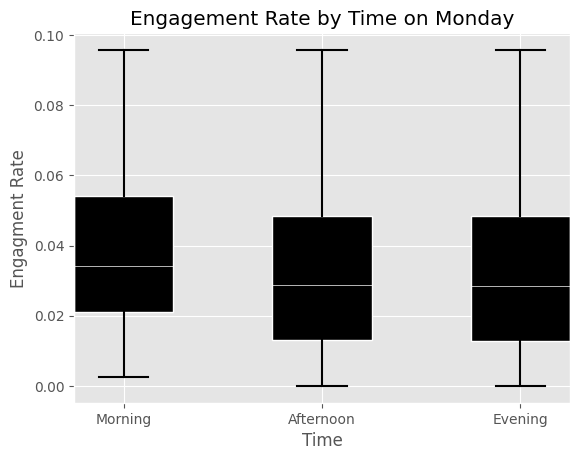

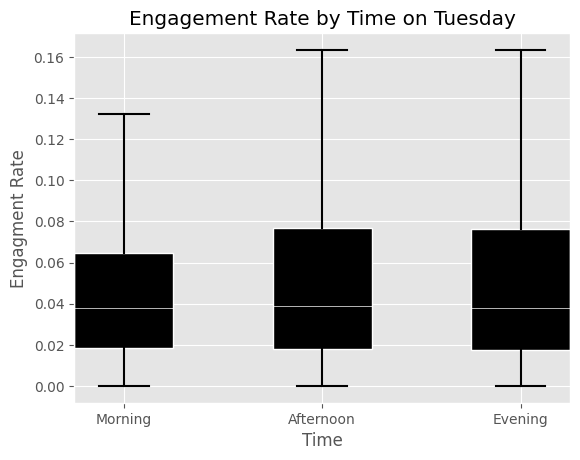

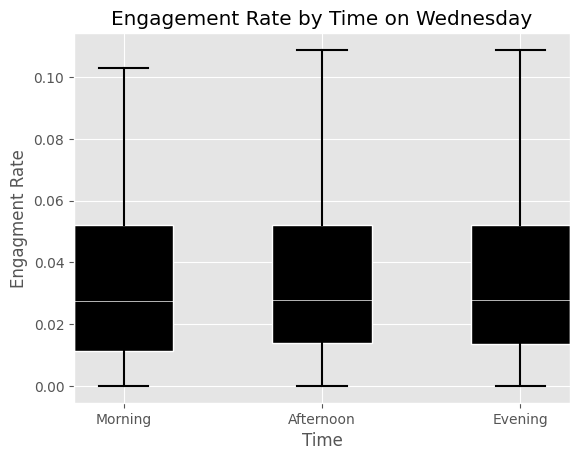

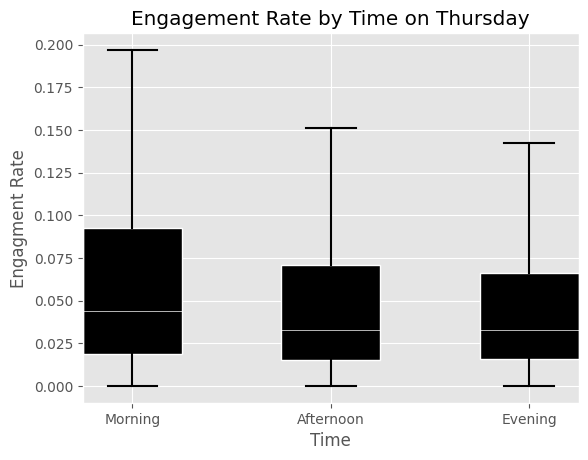

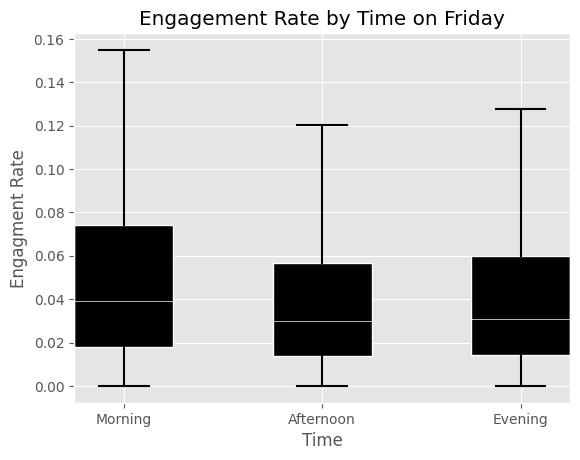

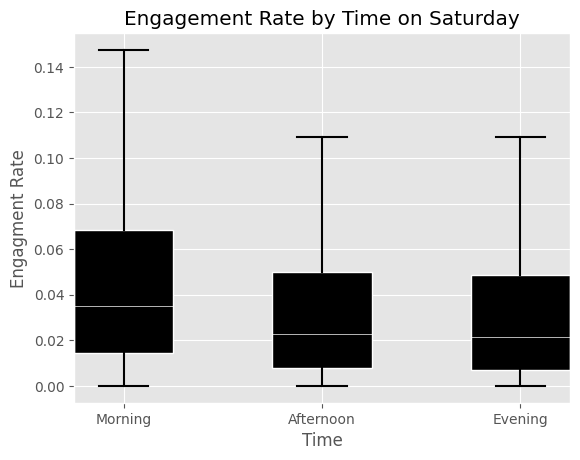

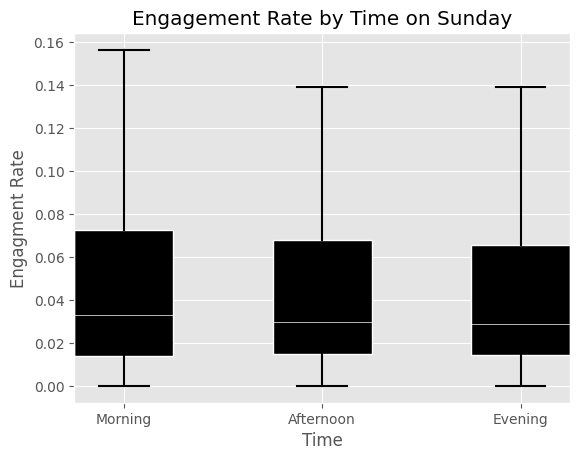

In [79]:
for day in dow_dict.keys():
  boxplot = [time_dict[day][0], time_dict[day][1], time_dict[day][2]]
  plt.boxplot(boxplot, positions=[i*2 for i in range(3)],labels=['Morning', 'Afternoon', 'Evening'], 
                widths=1, patch_artist=True,
                showmeans=False, showfliers=False,
                medianprops={"color": 'white', "linewidth": 0.5},
                boxprops={"facecolor": 'black', "edgecolor": "white",
                          "linewidth": 1},
                whiskerprops={"color": 'black', "linewidth": 1.5},
                capprops={"color": 'black', "linewidth": 1.5}
              )
  plt.title('Engagement Rate by Time on {}'.format(days_dict[day]))
  plt.ylabel('Engagment Rate')
  plt.xlabel('Time')
  plt.show()
  print()

ANSWER: The box plots and descriptive stats for each let us know that there are 3 distinct bumps in overall engagement on Tuesday, Thursday, and Sunday. These could be days that people spend more time at home, so they have more time to engage with social media posts they see. From these data, day of the week does in fact have a small effect on engagement rate. The second set of time data let us know that there could be a small bump in engagement in the mornings (except for Tuesday) 

# Question 3

(Part 1) How are our game titles doing in terms of social performance? (Part 2) Is there a specific game we should focus more on or less?

## Part 1

In [52]:
# Get unique games, in this case CS:GO, Dota 2, Valorant
games = list(set(data['Account']))
print(games)

['Content Creators', 'CSGO', 'Valorant', 'DOTA2', 'General ', 'General']


In [53]:
#'General' and 'General ' being in the data bugs me
def quickReplace(value):
    if value == 'General ':
      return 'General'
    return value

engagement['Account'] = engagement['Account'].apply(quickReplace)

games = list(set(engagement['Account']))
print(games)

# I don't really care about 'Countent Creators' or 'General' for this question
# BUT they will be talked about in the overall posting strategy

['Content Creators', 'CSGO', 'Valorant', 'DOTA2', 'General']


In [54]:
game_dict = get_stats_dict('Account', games)
stylers = print_stats_dict(game_dict, games, games)

,count,mean,std,min,25%,50%,75%,max
Total Impressions,35.000000,1291.028571,1337.370455,8.000000,187.500000,1372.000000,1857.000000,5685.000000
Total Engagements,35.000000,39.628571,33.538464,0.000000,11.500000,36.000000,54.500000,130.000000
Engagement Rate,35.000000,0.061717,0.076140,0.000000,0.025314,0.036885,0.061250,0.379310
,count,mean,std,min,25%,50%,75%,max
Total Impressions,198.000000,11686.454545,42612.836407,67.000000,1241.750000,2193.500000,5261.000000,445130.000000
Total Engagements,198.000000,466.343434,1336.395179,1.000000,18.250000,61.500000,200.250000,10909.000000
Engagement Rate,198.000000,0.041326,0.039821,0.004075,0.015533,0.024136,0.047957,0.171920
,count,mean,std,min,25%,50%,75%,max
Total Impressions,34.000000,675.852941,2089.353360,1.000000,50.000000,243.500000,481.250000,12320.000000
Total Engagements,34.000000,27.382353,78.151762,0.000000,4.250000,9.000000,21.750000,463.000000


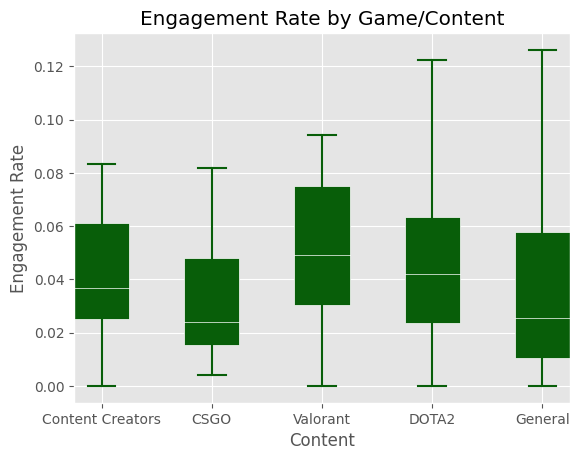

In [55]:
display_boxplot(game_dict, 'Engagement Rate', games, 'Engagement Rate by Game/Content', 
                'Content', 'Engagement Rate', games, c2='#085e09')

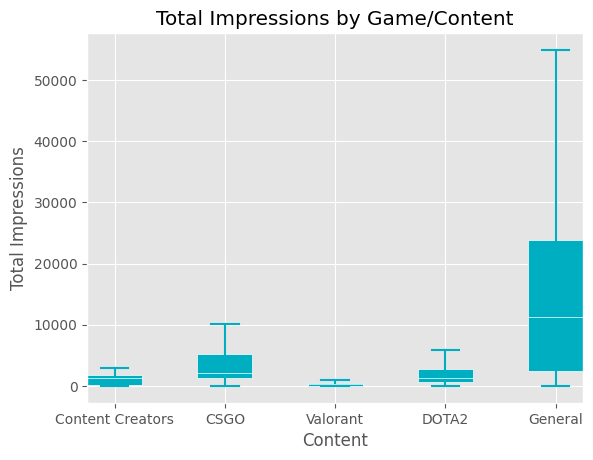

In [56]:
display_boxplot(game_dict, 'Total Impressions', games, 'Total Impressions by Game/Content', 
                'Content', 'Total Impressions', games, c2='#00aec2')

ANSWER: Valorant performs the worst, but Valorant is a realtively new team compared to CS:GO and Dota 2. CS:GO grabs the most impressions, but falls to Dota 2 in terms of engagement rate.

## Part 2

ANSWER: I would recommend CS:GO being the primary focus, it pulls the most impressions and CS:GO 2 just got announced for this coming Summer. There is definitely an uptick of interest in CS:GO right now. Valorant's small amount of data points don't convince me, and Dota 2 just won't pull the attention CS:GO will this summer.

# Question 4

What media type performs the best?

In [58]:
# Get unique media type
unique_media = list(set(data['Media Type']))
print(unique_media)

['Text', 'Carousel', 'Album', 'Video', 'Link', 'Photo', 'Mixed']


In [59]:
media_dict = get_stats_dict('Media Type', unique_media)
stylers = print_stats_dict(media_dict, unique_media, unique_media)

,count,mean,std,min,25%,50%,75%,max
Total Impressions,548.000000,5668.253650,20880.517678,8.000000,374.500000,992.000000,2605.250000,415457.000000
Total Engagements,548.000000,449.474453,1996.405910,0.000000,9.000000,24.000000,82.500000,29860.000000
Engagement Rate,548.000000,0.040839,0.043793,0.000000,0.015093,0.029447,0.049120,0.376578
,count,mean,std,min,25%,50%,75%,max
Total Impressions,9.000000,17854.333333,7319.563904,8380.000000,13062.000000,17411.000000,23121.000000,29416.000000
Total Engagements,9.000000,726.777778,618.686669,123.000000,327.000000,528.000000,894.000000,2144.000000
Engagement Rate,9.000000,0.037843,0.023892,0.012268,0.025428,0.030326,0.039021,0.092730
,count,mean,std,min,25%,50%,75%,max
Total Impressions,1.000000,20.000000,nan,20.000000,20.000000,20.000000,20.000000,20.000000
Total Engagements,1.000000,8.000000,nan,8.000000,8.000000,8.000000,8.000000,8.000000


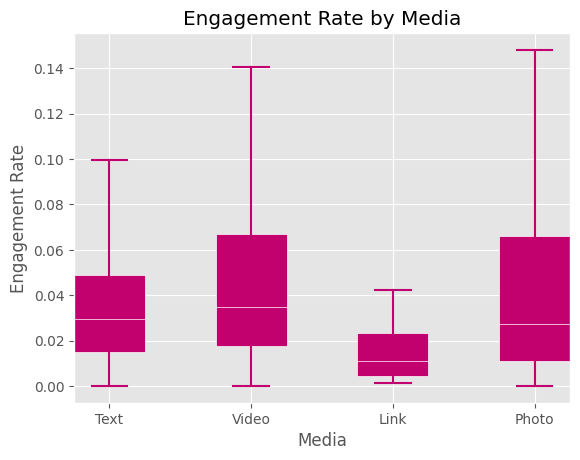

In [60]:
# I could probably omit Carousel, Mixed, and Album due to low data count
for media in ['Carousel', 'Mixed', 'Album']:
  unique_media.remove(media)

display_boxplot(media_dict, 'Engagement Rate', unique_media, 'Engagement Rate by Media', 
                'Media', 'Engagement Rate', unique_media, c2='#c2006e')

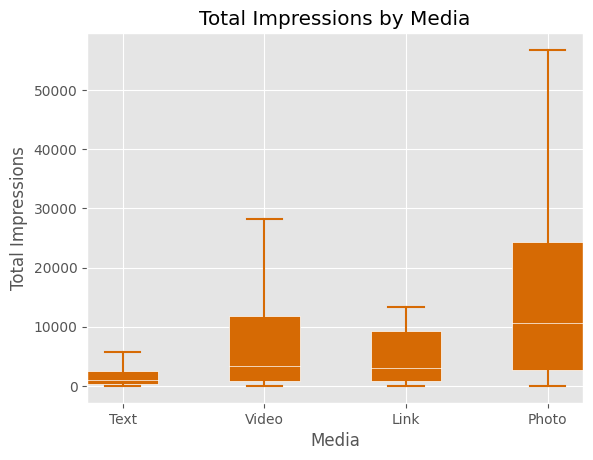

In [61]:
display_boxplot(media_dict, 'Total Impressions', unique_media, 'Total Impressions by Media', 
                'Media', 'Total Impressions', unique_media, c2 ='#d66a04')

ANSWER: I would say photo performs the best. Video is close in engagement rate, but photos seem to have an extremely broad reach. I believe that pushes photo as the best performing media type.

# Question 5

What is our best performing campaign?

In [72]:
# Get unique vals
unique_campaigns = list(set(data['Campaign Name']))
print(unique_campaigns)

['Evil Exhibited', 'Evergreen', nan, 'Community Engagement']


In [73]:
unique_campaigns.remove(np.nan)
engagement = engagement[engagement['Campaign Name'] != np.nan]

In [74]:
campaign_dict = get_stats_dict('Campaign Name', unique_campaigns)
stylers = print_stats_dict(campaign_dict, unique_campaigns, unique_campaigns)

,count,mean,std,min,25%,50%,75%,max
Total Impressions,391.000000,14630.061381,41864.479649,1.000000,616.500000,3064.000000,13302.000000,449596.000000
Total Engagements,391.000000,473.028133,1443.597061,0.000000,9.000000,43.000000,228.000000,11048.000000
Engagement Rate,391.000000,0.028727,0.025367,0.000000,0.010745,0.022059,0.040451,0.159882
,count,mean,std,min,25%,50%,75%,max
Total Impressions,161.000000,8252.975155,19276.139191,12.000000,389.000000,1180.000000,10618.000000,172597.000000
Total Engagements,161.000000,267.869565,886.796335,1.000000,16.000000,47.000000,143.000000,8074.000000
Engagement Rate,161.000000,0.035105,0.024720,0.006562,0.016784,0.030916,0.044218,0.136493
,count,mean,std,min,25%,50%,75%,max
Total Impressions,1369.000000,17201.246165,31643.789014,29.000000,2284.000000,9785.000000,21236.000000,452337.000000
Total Engagements,1369.000000,1441.848795,3722.009993,0.000000,35.000000,171.000000,788.000000,41102.000000


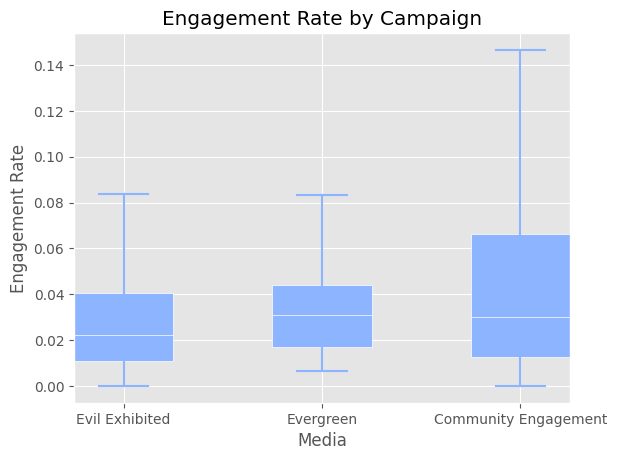

In [75]:
display_boxplot(campaign_dict, 'Engagement Rate', unique_campaigns, 'Engagement Rate by Campaign', 
                'Media', 'Engagement Rate', unique_campaigns, c2='#8cb4ff')

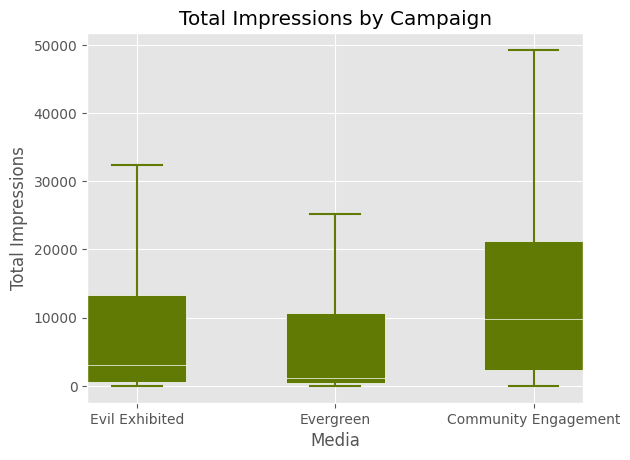

In [76]:
display_boxplot(campaign_dict, 'Total Impressions', unique_campaigns, 'Total Impressions by Campaign', 
                'Media', 'Total Impressions', unique_campaigns, c2='#617a04')

ANSWER: With the descriptive stats available and the above charts, it seems 'Community Engagement' is the best performing campaign. It is interesting to note that 'Evil Exhibited' was the only campaign to never get a 0% engagement rate on any post, but that could be for lack of data points.

# Question 6

Define out a posting strategy for our social channels based on your discoveries.


ANSWER:

What have we discovered:

- 3-6% typical engagement rate
- Probability of achieving a 15% engagement rate is 7.89%
- Engagement rate bump Tuesday, Thursday, Sunday
- CS:GO highest engagement, Dota 2 highest engagement rate
- Photo is a high performing media type
- Community engagement was the strongest campaign type

What date and time should we post?
 - The posting schedule shouldn't be limited to specific days like Tuesday, Thursday, and Sunday, but rather consider the preferences and routines of your audience. As noted in [1, Nestor], 32% of e-sports viewers are between the ages of 16 and 24, while 30% fall into the 25 to 34-year-old range. You could make the assumption that these demographics likely have busy lives, including full school and/or work commitments. To encourage higher engagement, it's crucial to take into account their daily routines and behaviors. For instance, posting early and late during the workweek may generate more enthusiasm and interaction. By sharing content when people have just started or finished their day (morning bump in engagement rate data), such as before work or in the evening, you can catch them during their leisure time.

What should we post?
  - Focus on CS:GO this Summer: Given that CS:GO generates the highest impressions and CS:GO 2 is coming out this Summer, prioritize this in your social media content strategy. General content always performs well, too. Other games like Dota 2 and Valorant shouldn't be completely pushed to the side, but its important to know what the focus should be.

What type of media? 
- Utilize Photos: Since photos have been identified as a high-performing media type, incorporate captivating visuals into your posts. Share images of your team members, in-game moments, tournaments, and behind-the-scenes glimpses. Visual content seems to attract more attention and encourage user engagement. But, while photos are effective, we can't limit ourselves to a single media type. You could use a photo as the initial post to draw people in, then poist a URL or video in the replies below it.

How should we interact with followers?
- Since community engagement was identified as a strong campaign type, make it a priority. Encourage interactions with your followers. Respond to comments, ask questions, run polls, and create opportunities for fans to share their opinions and experiences. This will help build the sense of community and loyalty around fans and the team.

Questions worth answering in the future. More data could help answer these questions in detail. 
- Which social media account performs the best (TikTok vs Twitter vs Youtube, etc.)
- What content does the best on each social media?
- What media types do the best on each social media?

# Question 7

What suggestions would you give to the social media team if they want to expand their presence (e.g. if our CSGO youtube channel is doing well should we expand to TikTok)?



In [ ]:
# Get unique games, in this case CS:GO, Dota 2, Valorant
accounts = list(set(data['Account Type']))
print(accounts)
labels = ['Youtube', 'LinkedIn', 'Twitter', 'TikTok', 'Instagram', 'Facebook']

['YOUTUBE', 'LINKEDIN_COMPANY', 'TWITTER', 'TIKTOK_BUSINESS', 'INSTAGRAM', 'FBPAGE']


In [ ]:
account_dict = get_stats_dict('Account Type', accounts)
stylers = print_stats_dict(account_dict, labels, accounts)

,count,mean,std,min,25%,50%,75%,max
Total Impressions,150.000000,1589.353333,5468.140640,1.000000,286.750000,580.000000,1646.750000,64879.000000
Total Engagements,150.000000,68.853333,361.222150,0.000000,9.000000,23.000000,44.750000,4388.000000
Engagement Rate,150.000000,0.044717,0.042813,0.000000,0.024922,0.036534,0.050454,0.379310
,count,mean,std,min,25%,50%,75%,max
Total Impressions,22.000000,1945.500000,1086.290532,888.000000,1164.750000,1648.000000,2215.500000,5270.000000
Total Engagements,22.000000,38.590909,37.700144,0.000000,16.250000,28.500000,41.500000,133.000000
Engagement Rate,22.000000,0.017950,0.009150,0.000000,0.013239,0.016899,0.023356,0.039607
,count,mean,std,min,25%,50%,75%,max
Total Impressions,1655.000000,11782.837462,33270.864949,8.000000,895.000000,2432.000000,12964.500000,452337.000000
Total Engagements,1655.000000,365.292447,1048.711221,0.000000,21.000000,82.000000,276.500000,12348.000000


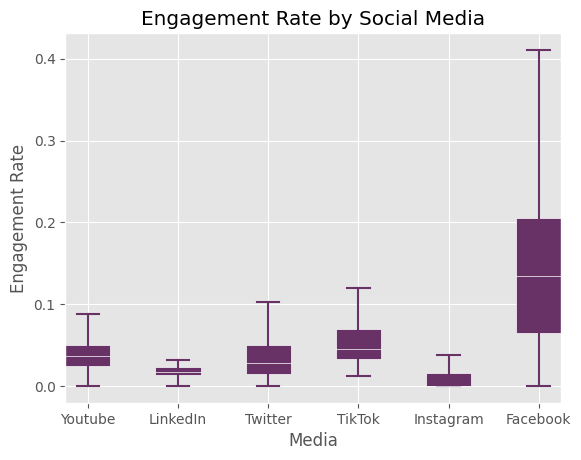

In [ ]:
display_boxplot(account_dict, 'Engagement Rate', labels, 'Engagement Rate by Social Media', 
                'Media', 'Engagement Rate', accounts, c2 ='#693267')

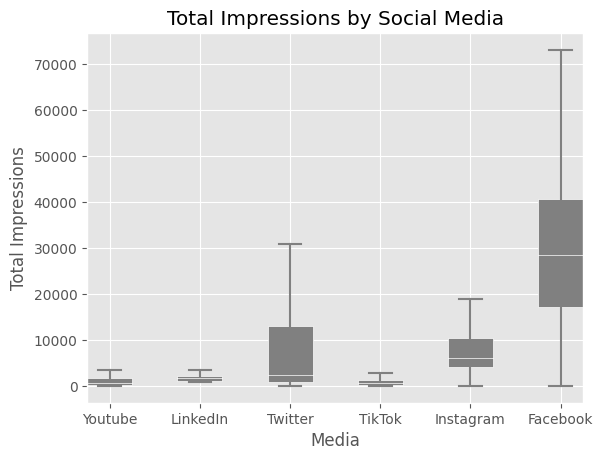

In [ ]:
display_boxplot(account_dict, 'Total Impressions', labels, 'Total Impressions by Social Media', 
                'Media', 'Total Impressions', accounts, c2 ='grey')

ANSWER: I think both the Youtube channel and Tiktok could benefit from being the next platforms to focus your growth on. TikTok and Youtube have fairly healthy engagement rates for how relatively low (compared to FB or Twitter) their impressions are. A concerted effort on these websites could yield good results. Collecting data on types of engagements (comments, likes, shares, etc.) could be helpful too. That way, we have more detailed metrics if you need to course correct any particular account. You can see what community engagement methods garnered the most comments, or what kind of post got the most shares. 

# References

1. Gilbert, Nestor. “75 Significant Esports Statistics: 2023 Market, Viewership &amp; Investment Growth.” Financesonline.Com, 17 May 2023, financesonline.com/esports-statistics/. 